# Variational Inference

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd
import scipy.stats
import warnings
warnings.filterwarnings('ignore')

## <span style="color:Orange">Overview</span>

Most Bayesian inference problems cannot be solved exactly, so require an approximate method. The MCMC method is one such method, invented in the 1950s. <span style="color:violet">Variational inference</span> is an alternative approximate method, invented in the 1990s:
 - <span style="color:LightGreen">MCMC</span>: provides an approximate description of the exact posterior distribution (using <span style="color:violet">sampling</span>).

 - <span style="color:LightGreen">VI</span>: provides an exact description of an approximate posterior distribution (using <span style="color:violet">optimization</span>).

The underlying assumptions and numerical algorithms involved (sampling and optimization) are fundamentally different, leading to different tradeoffs between these methods.

The essence of VI is to first define a family of PDFs that balance two competing criteria:
 - convenient for calculations, and

 - flexible enough to approximately match some unknown target PDF.

We then select the family member that is "closest" to the target. In a Bayesian context, our target PDF is a posterior distribution, but VI is a more general technique for finding approximate PDFs.

## <span style="color:Lightgreen">Kullback-Leibler Divergence</span>

Variational inference relies on a concept of "closeness" between two PDFs, which we call $q(\theta)$ and $p(\theta)$. Note that we are talking about "separation" in an abstract function space, rather than a coordinate space. Just as with coordinate separation, there are many possible valid definitions, e.g.

$$ \Large
(\sum_i (x_i - y_i)^2)^{1/2} \quad, \quad
\sum_i |x_i - y_i| \quad, \quad
\max_i\, |x_i - y_i| \quad, \ldots
$$

VI uses the [Kullback Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) to measure the "closeness" of PDFs $q(\theta)$ and $p(\theta)$:

$$ \Large
\boxed{
\text{KL}( q \parallel p ) \equiv \int d\theta\, q(\theta)\, \log\frac{q(\theta)}{p(\theta)}} \; .
$$

Since $q$ is a PDF, KL divergence can also be written as a difference of expectation values over $q$:

$$ \Large
\text{KL}( q \parallel p ) = \langle \log q(\theta)\rangle_q - \langle \log p(\theta)\rangle_q \; .
$$

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:Violet">EXERCISE</span>___:
 - Is KL divergence symmetric, $\text{KL}(q\parallel p) = \text{KL}(p\parallel q)$?

 - What is the value of $\text{KL}(q\parallel p)$ when $p = q$?

 - What happens to the integrand when either $q(\theta)$ or $p(\theta)$ approaches zero?

 - What bounds, if any, can you place on the value of $\text{KL}(q\parallel p)$ given that $p$ and $q$ are PDFs?

KL divergence is not symmetric since exchanging $q$ and $p$ in the integrand changes its value. This makes KL divergence an unusual measure of separation and means that it is not a true
[metric](https://en.wikipedia.org/wiki/Metric_%28mathematics%29).

When $p=q$, the log zeros the integrand (except possibly where $q$ has a singularity), resulting in a KL divergence of zero. This is what we would expect for a useful measure of separation.

When $q \rightarrow 0$ the combination $q \log q \rightarrow 0$. When $p(\theta)\rightarrow 0$, the log term diverges $\log(1/p)\rightarrow +\infty$. As a result, the KL integrand blows up wherever $\theta$ is very unlikely according to $p$ doesn't care when $\theta$ is very unlikely according to $q$.

A PDF is always $\ge 0$ but not bounded from above, so the KL divergence is not bounded from above. However, nothing prevents $q(\theta) < p(\theta)$, so the integrand can be negative (due to the log) even with $p, q \ge 0$.

It turns out that the KL divergence is always $\ge 0$ but this is not obvious. The proof relies on the [log sum inequality](https://en.wikipedia.org/wiki/Log_sum_inequality), which in turns relies on [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen's_inequality) which we met earlier.

The key insight is that the KL divergence is [convex](https://en.wikipedia.org/wiki/Convex_function) in $q$:

$$ \Large
\text{KL}\big(\lambda q_1 + (1-\lambda) q_2\parallel p\big) ~ \le ~
\lambda\,\text{KL}(q_1\parallel p) + (1-\lambda)\,\text{KL}(q_2\parallel p) \; .
$$

since, for any value of $\theta$, $p$ and $q$ are just numbers and the integrand

$$ \Large
f(q) = q \log q/p
$$

is a convex function of $q$:

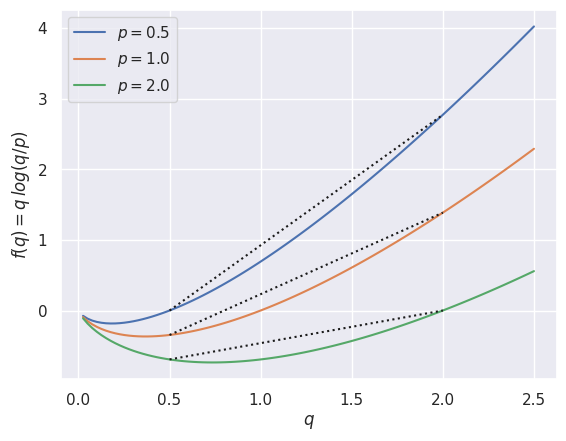

In [12]:
def plot_convex():
    q = np.linspace(0, 2.5, 100)[1:]
    f = lambda q, p: q * np.log(q / p)
    qlo, qhi = 0.5, 2
    for p in (0.5, 1, 2):
        plt.plot(q, f(q, p), label='$p={:.1f}$'.format(p))
        plt.plot([qlo, qhi], [f(qlo,p), f(qhi,p)], 'k:')
    plt.legend()
    plt.xlabel('$q$')
    plt.ylabel('$f(q) = q\, log (q/p)$')
    
plot_convex()

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

In [13]:
def calculate_KL(log_q, log_p, theta):
    """Calculate the KL divergence of q wrt p for single-parameter PDFs.

    Uses the trapezoid rule for the numerical integration. Integrals are only
    calculated over the input theta range, so are not valid when p or q have
    significant mass outside this range.

    Regions where either PDF is zero are handled correctly, although an
    integrable singularity due to p=0 will result in a divergent KL because the
    inputs are tabulated.

    Parameters
    ----------
    log_q : array
        Values of log q(theta, s) tabulated on a grid with shape (ns, ntheta)
        of s (axis=0) and theta (axis=1).
    log_p : array
        Values of log p(theta) tabulated on a grid with shape (ntheta) of theta.
    theta : array
        Values of theta where log_q and log_p are tabulated.

    Returns
    -------
    tuple
        Tuple (KL, integrand) where KL is an array of ns divergence values and
        integrand is an array with shape (ns, ntheta) of KL integrands.
    """
    # special handling for q=0.
    q_log_q = np.zeros_like(log_q)
    nonzero = log_q > -np.inf
    q_log_q[nonzero] = log_q[nonzero] * np.exp(log_q[nonzero])
    integrand = q_log_q - log_p * np.exp(log_q)
    return np.trapezoid(integrand, theta), integrand


def plot_KL(q, q_scale_range, p, p_scale, theta_range):
    """Explanatory plots for the KL divergence.

    q and p are arbitrary PDFs defined in scipy.stats. q represents a
    family of PDFs by allowing its scale factor to vary in some range.
    The target pdf p uses a fixed scale factor.

    Parameters
    ----------
    q : str
        Name of a 1D continous random variable defined in scipy.stats.
    q_scale_range : list
        List [lo, hi] giving the range of scale factors to allow in defining the
        q family of PDFs.
    p : str
        Name of a 1D continous random variable defined in scipy.stats.
    p_scale : float
        Fixed scale factor to use for the target PDF p.
    theta_range : list
        List [lo, hi] giving the range to use for plotting and integration.
    """
    q = getattr(scipy.stats, q)
    p = getattr(scipy.stats, p)

    theta = np.linspace(*theta_range, 251)
    log_p = p.logpdf(theta, scale=p_scale)
    assert np.all(np.isfinite(log_p))

    q_scale = np.linspace(*q_scale_range, 101)
    log_q = q.logpdf(theta, scale=q_scale[:, np.newaxis])

    KLs, KL_ints = calculate_KL(log_q, log_p, theta)
    ibest = np.argmin(KLs)

    fig = plt.figure(figsize=(12, 7))
    ax = [plt.subplot2grid((2,2), (0,0)), plt.subplot2grid((2,2), (1,0)),
          plt.subplot2grid((2,2), (0,1), rowspan=2)]
    cmap = sns.color_palette('bright', n_colors=1 + len(KLs)).as_hex()

    ax[0].plot(theta, np.exp(log_p), '-', lw=10, c=cmap[0],
               alpha=0.25, label='$p(\\theta)$')
    ax[0].axhline(0., color='gray', lw=1)
    ax[1].axhline(0., color='gray', lw=1)
    ax[2].axhline(0., color='gray', lw=1)
    ax[2].plot(q_scale, KLs, 'k-', label='KL$(q(s) \parallel p)$')
    for i, idx in enumerate((0, ibest, -1)):
        c = cmap[i + 1]
        label = '$q(\\theta;s={:.2f})$'.format(q_scale[idx])
        ax[0].plot(theta, np.exp(log_q[idx]), '--', lw=2,
                   alpha=1, c=c, label=label)
        ax[1].plot(theta, KL_ints[idx], '--', lw=2, alpha=1, c=c)
        ax[2].scatter(q_scale[idx], KLs[idx], lw=0, c=cmap[i + 1], s=150)
    ax[0].legend()
    ax[0].set_ylabel('$p(x), q(\\theta; s)$', fontsize='x-large')
    ax[0].set_xlim(*theta_range)
    ax[0].set_xticklabels([])
    ax[0].set_yticks([])
    ax[1].set_ylabel('KL$(q \parallel p)$ integrand', fontsize='x-large')
    ax[1].set_xlim(*theta_range)
    ax[1].set_xlabel('$\\theta$', fontsize='large')
    ax[1].set_yticks([])
    ax[2].set_xlabel('$q(\\theta;s)$ scale $s$', fontsize='large')
    ax[2].legend(loc='upper center', fontsize='x-large')
    plt.subplots_adjust(left=0.05, hspace=0.05, wspace=0.1)


def calculate_ELBO(log_q, log_likelihood, log_prior, theta):
    """Calculate the ELBO of q for single-parameter PDFs.
    """
    KLqP, integrand = calculate_KL(log_q, log_prior, theta)
    integrand = np.exp(log_q) * log_likelihood - integrand
    return np.trapezoid(integrand, theta), integrand


def plot_ELBO(q, q_scale_range, likelihood, prior, theta_range, n_data, seed=123):
    """Explanatory plots for the evidence lower bound (ELBO).

    Data is modeled with a single offset (loc) parameter theta with an arbitrary
    likelihood and prior. A random sample of generated data is used to calculate
    the posterior, which is approximated by adjusting the scale parameter of
    the arbitrary PDF family q.

    Parameters
    ----------
    q : str
        Name of a 1D continous random variable defined in scipy.stats.
    q_scale_range : list
        List [lo, hi] giving the range of scale factors to allow in defining the
        q family of PDFs.
    likelihood : str
        Name of a 1D continous random variable defined in scipy.stats.
    prior : str
        Name of a 1D continous random variable defined in scipy.stats.
    theta_range : list
        List [lo, hi] giving the range to use for plotting and integration.
        The true value of theta used to generate data is (lo + hi) / 2.
    n_data : int
        Number of data points to generate by sampling from the likelihood with
        theta = theta_true.
    seed : int
        Random number seed to use for reproducible results.
    """
    q = getattr(scipy.stats, q)
    likelihood = getattr(scipy.stats, likelihood)
    prior = getattr(scipy.stats, prior)

    # Generate random data using the midpoint of the theta range as the
    # true value of theta for sampling the likelihood.
    theta = np.linspace(*theta_range, 251)
    theta_true = 0.5 * (theta[0] + theta[-1])
    D = likelihood.rvs(
        loc=theta_true, size=n_data,
        random_state=np.random.RandomState(seed=seed))

    # Calculate the likelihood and prior for each theta.
    log_L = likelihood.logpdf(D, loc=theta[:, np.newaxis]).sum(axis=1)
    log_P = prior.logpdf(theta)

    # Calculate the evidence and posterior.
    log_post = log_L + log_P
    log_evidence = np.log(np.trapezoid(np.exp(log_post), theta))
    log_post -= log_evidence
    assert np.all(np.isfinite(log_post))

    q_scale = np.linspace(*q_scale_range, 101)
    log_q = q.logpdf(theta, scale=q_scale[:, np.newaxis])

    KLs, KL_ints = calculate_KL(log_q, log_post, theta)
    ibest = np.argmin(KLs)

    ELBOs, ELBO_ints = calculate_ELBO(log_q, log_L, log_P, theta)

    fig = plt.figure(figsize=(12, 8))
    ax = [plt.subplot2grid((2,2), (0,0)), plt.subplot2grid((2,2), (1,0)),
          plt.subplot2grid((2,2), (0,1)), plt.subplot2grid((2,2), (1,1))]
    cmap = sns.color_palette('bright', n_colors=1 + len(KLs)).as_hex()

    ax[0].plot(theta, np.exp(log_post), '-', lw=10, c=cmap[0],
               alpha=0.25, label='$P(\\theta\mid D)$')
    ax[0].axhline(0., color='gray', lw=1)
    ax[1].axhline(0., color='gray', lw=1)
    ax[2].axhline(0., color='gray', lw=1)
    ax[2].plot(q_scale, KLs, 'k-', label='KL$(q(s) \parallel p)$')
    ax[2].plot(q_scale, log_evidence - ELBOs, 'k:', lw=6,
               alpha=0.5, label='$\log P(D) - ELBO(q(s))$')
    for i, idx in enumerate((0, ibest, -1)):
        c = cmap[i + 1]
        label = '$q(\\theta;s={:.2f})$'.format(q_scale[idx])
        ax[0].plot(theta, np.exp(log_q[idx]), '--', lw=2,
                   alpha=1, c=c, label=label)
        ax[1].plot(theta, KL_ints[idx], '--', lw=2, alpha=1, c=c)
        ax[2].scatter(q_scale[idx], KLs[idx], lw=0, c=c, s=150)
    ax[0].legend()
    ax[0].set_ylabel('$p(x), q(\\theta; s)$', fontsize='x-large')
    ax[0].set_xlim(*theta_range)
    ax[0].set_xlabel('Model parameter $\\theta$', fontsize='large')
    ax[0].set_yticks([])
    ax[1].set_ylabel('KL$(q \parallel p)$ integrand', fontsize='x-large')
    ax[1].set_xlim(*theta_range)
    ax[1].set_xlabel('Model parameter $\\theta$', fontsize='large')
    ax[1].set_yticks([])
    ax[2].set_xlabel('$q(\\theta;s)$ scale $s$', fontsize='large')
    ax[2].legend(loc='upper center', fontsize='x-large')

    x_lim = 1.1 * np.max(np.abs(D))
    ax[3].hist(D, density=True, range=(-x_lim, +x_lim), histtype='stepfilled')
    x = np.linspace(-x_lim, +x_lim, 250)
    dtheta = 0.25 * (theta[-1] - theta[0])
    for theta, ls in zip(
        (theta_true - dtheta, theta_true, theta_true + dtheta),
        ('--', '-', ':')):
        label = '$P(x\mid \\theta={:+.2f})$'.format(theta)
        ax[3].plot(x, likelihood.pdf(x, loc=theta), 'k', ls=ls, label=label)
    ax[3].set_xlabel('Observed sample $x$')
    ax[3].set_xlim(-x_lim, +x_lim)
    ax[3].legend()

    plt.subplots_adjust(
        left=0.05, right=0.95, hspace=0.25, wspace=0.15, top=0.95)
    fig.suptitle(
        '$\\theta_{\text{true}}' + ' = {:.2f}$ , $\log P(D) = {:.1f}$'
        .format(theta_true, log_evidence), fontsize='large')

We will use the `plot_KL` function above to explore some examples:

In [14]:
help(plot_KL)

Help on function plot_KL in module __main__:

plot_KL(q, q_scale_range, p, p_scale, theta_range)
    Explanatory plots for the KL divergence.

    q and p are arbitrary PDFs defined in scipy.stats. q represents a
    family of PDFs by allowing its scale factor to vary in some range.
    The target pdf p uses a fixed scale factor.

    Parameters
    ----------
    q : str
        Name of a 1D continous random variable defined in scipy.stats.
    q_scale_range : list
        List [lo, hi] giving the range of scale factors to allow in defining the
        q family of PDFs.
    p : str
        Name of a 1D continous random variable defined in scipy.stats.
    p_scale : float
        Fixed scale factor to use for the target PDF p.
    theta_range : list
        List [lo, hi] giving the range to use for plotting and integration.



<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:Violet">EXAMPLE</span>___: For our first example, we chose a family $q$ that includes the target $p$. This is generally not feasible but nicely demonstrates our earlier claim that KL $\ge 0$ with KL $=0$ when $q=p$.

In this example, we explore the family of PDFs $q(\theta; s)$ by varying the scale factor $s$. More generally, the family can be explored with any (multidimensional) parameterization that is convenient for calculations. We need a parameterization of the family $q$ in order to use standard optimization algorithms to find the minimum KL divergence.

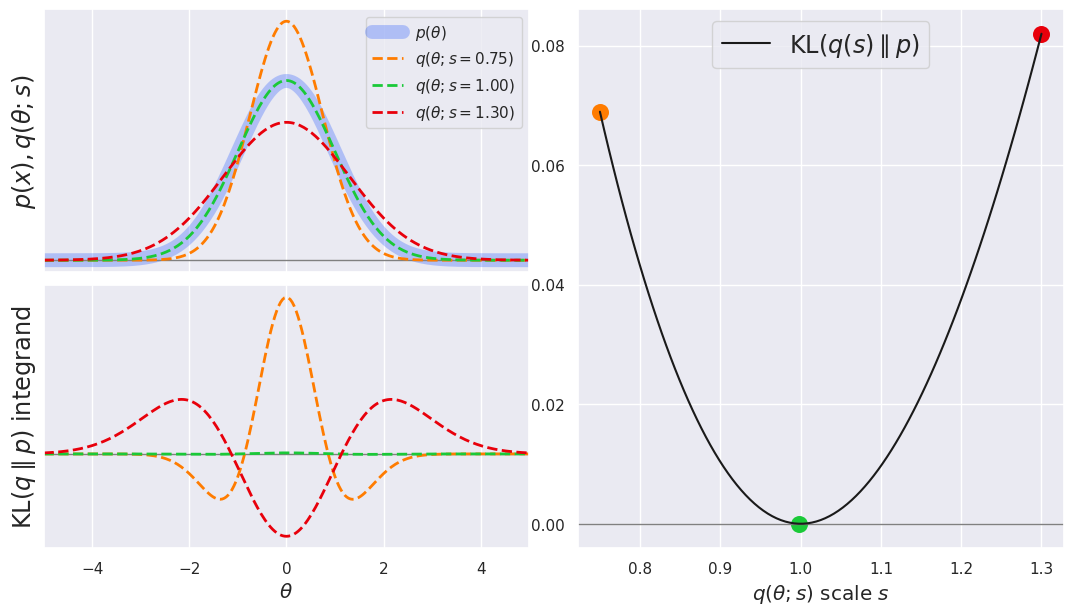

In [15]:
plot_KL(q='norm', q_scale_range=[0.75, 1.3], p='norm', p_scale=1.0, theta_range=[-5, +5])

Note how (in the bottom left panel) the KL integrand has positive and negative regions: the net area is always positive, however, since KL $\ge 0$.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:Violet">EXAMPLE</span>___: For our next example, we consider the more realistic case where the family $q$ does not include the target $p$ so we have to settle for the "closest" approximation, according to the KL divergence:

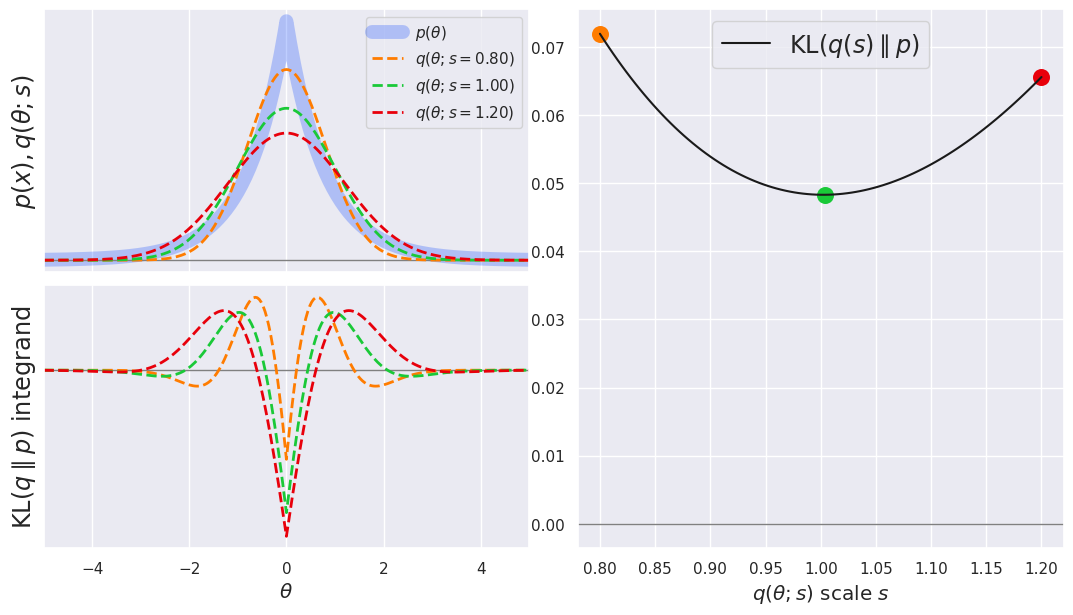

In [16]:
plot_KL(q='norm', q_scale_range=[0.8, 1.2], p='laplace', p_scale=0.8, theta_range=[-5, +5])

Notice how the "closest" $q$ now has KL $>0$.  It also avoids regions where $p \simeq 0$, since that would blow up the KL integrand.

The example above showed that a Gaussian PDF with $s \simeq 1$ gives the best match a Laplacian PDF with $s = 0.8$.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:Violet">EXAMPLE</span>___: Next, turn this around and find the closest Laplacian $q$ to a Gaussian $p$ with $s = 1$:

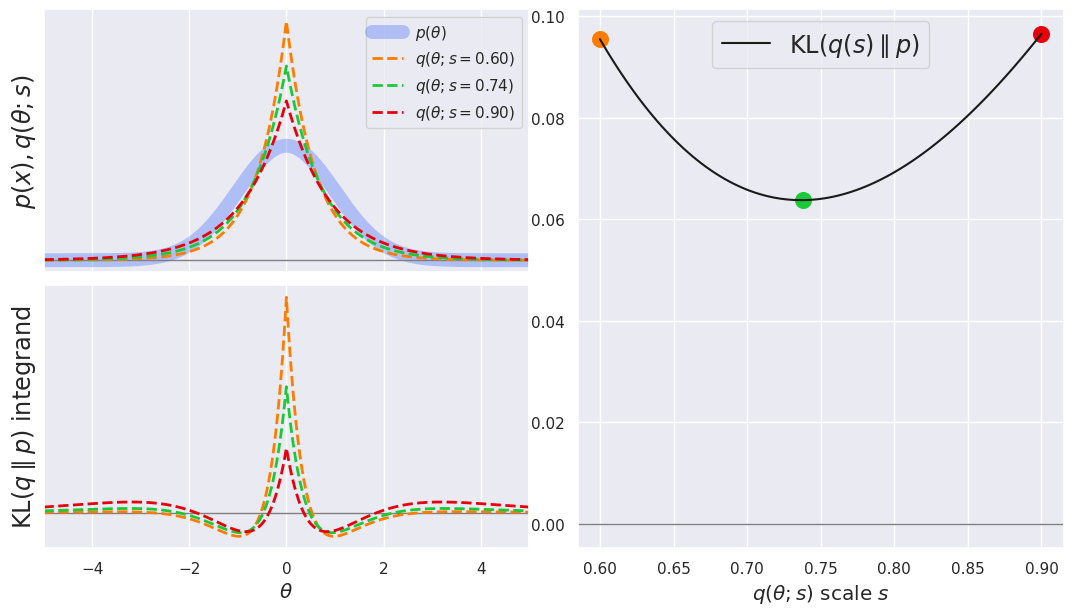

In [17]:
plot_KL(q='laplace', q_scale_range=[0.6, 0.9], p='norm', p_scale=1.0, theta_range=[-5, +5])

The answer is a Laplacian with $s\simeq 0.74$, rather than $0.8$, so a round trip does not end up back where we started!  However, this shouldn't surprise us because the KL divergence is not symmetric in $q$ and $p$.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

Note that the KL divergences between Gaussian and Laplacian distributions in the examples above can all be calculated analytically, which is useful for testing but not generally true. The analytic results are summarized below, for reference:

$$
\begin{aligned}
\text{KL}_{qp}[G(s_1)\parallel G(s_2)] &=
\frac{1}{2} r^2 - \log r - \frac{1}{2} \quad& \quad
\text{KL}_{qp}[G(s_1)\parallel L(s_2)] &=
\sqrt{\frac{2}{\pi}} r - \log\left( \sqrt{\frac{\pi}{2}} r\right) - \frac{1}{2} \\
\text{KL}_{qp}[L(s_1)\parallel G(s_2)] &=
r^2 - \log\left(\sqrt{\frac{2}{\pi}}r\right) - 1 \quad& \quad
\text{KL}_{qp}[L(s_1)\parallel L(s_2)] &=
r - \log r - 1 \; ,
\end{aligned}
$$

where $r \equiv s_1/s_2$ is the ratio of scale parameters.  With $s_2$ fixed, the corresponding minimum KL divergences are:

$$
\begin{aligned}
\min \text{KL}_{qp}[G(s_1=s_2)\parallel G(s_2)] &= 0 \quad& \quad
\min \text{KL}_{qp}[G(s_1=(\pi/2)s_2)\parallel L(s_2)] &=
\sqrt{\frac{2}{\pi}} -  \frac{1}{2}\log\frac{\pi}{2} - \frac{1}{2} \\
\min \text{KL}_{qp}[L(s_1=s_2/\sqrt{2})\parallel G(s_2)] &=
\frac{1}{2}\log\frac{\pi}{2} \quad& \quad
\min \text{KL}_{qp}[L(s_1=s_2)\parallel L(s_2)] &= 0 \; .
\end{aligned}
$$

## <span style="color:Lightgreen">Evidence Lower Bound</span>

The KL divergence is a generic method to find the parameterized PDF $q(x,s)$ that "best" approximates some target PDF $p(x)$.  For Bayesian inference, the $p$ we care about is the posterior:

$$ \Large
p(\theta) = P(\theta\mid D) = \frac{P(D\mid \theta)\, P(\theta)}{P(D)} \; ,
$$

where:
 - $\theta$ are the model parameters and $D$ represents the observed data.

 - $P(D\mid \theta)$ is the likelihood of the data assuming parameters $\theta$.

 - $P(\theta)$ is our prior on the parameters.

 - $P(D)$ is the "evidence".
 
Since we generally cannot calculate the evidence $P(D)$, a useful inference method should not require that we know its value.
 
The <span style="color:Violet">variational Bayesian inference</span> method has three steps:
 - Define a family of PDFs $q(\theta; s)$ that approximate the true posterior $P(\theta\mid D)$.
 - Use optimization to find the value $s^\ast$ that, according to the KL divergence, best approximates the true posterior.
 - Use $q(\theta; s=s^\ast)$ as an approximation of the true posterior for calculating expectation values, etc.
 
The main tradeoff is in picking the approximate PDF family $q$. A more flexible choice will generally do a better job of approximating the true posterior, but also require more difficult calculations.

Plugging the posterior into the KL definition, we can rewrite:

$$ \Large
\begin{aligned}
\text{KL}(q\parallel p) &= \int d\theta\, q(\theta) \log\left[
\frac{P(D)\, q(\theta)}{P(D\mid \theta)\, P(\theta)}
\right] \\
&= \int d\theta\, q(\theta) \left[\log P(D) +
\log\frac{q(\theta)}{P(\theta)} - \log P(D\mid\theta) \right] \\
&= \log P(D) + \text{KL}(q\parallel P) - \int d\theta\, q(\theta) \log P(D\mid\theta) \; .
\end{aligned}
$$

The three terms on the right-hand side are:
 - The log of the evidence $P(D)$.

 - The KL divergence of $q(\theta)$ with respect to the prior $P(\theta)$.

 - The $q$-weighted log-likelihood of the data.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:Violet">DISCUSS</span>___: Describe the $q(\theta)$ that would minimize the contribution of each term to their sum (assuming a fixed dataset $D$).

Solution:
 - The log of the evidence is a constant offset in the sum, independent of $q$.\

 - The KL divergence term is minimized when $q(\theta) = P(\theta)$, i.e., it drives $q$ to look like the prior.

 - The log-likelihood term is minimized when $q(\theta)$ prefers parameters $\theta$ that explain the data.
 
The competition between the last two terms is exactly what we need for a useful learning rule that balances prior knowledge with the information gained from new data.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

We can rewrite the expression above in terms of the log-evidence as:

$$ \Large
\log P(D) = \int d\theta\, q(\theta) \log P(D\mid\theta) - \text{KL}(q\parallel P) + \text{KL}(q\parallel p) \; .
$$

Since the last term is $\ge 0$ (since any KL $\ge 0$), we find:

$$ \Large
\log P(D) \ge \int d\theta\, q(\theta) \log P(D\mid\theta) - \text{KL}(q\parallel P) \; ,
$$

and call this right-hand side the ___<span style="color:Violet">evidence lower bound</span>___ (ELBO):

$$ \Large
\text{ELBO}(q) \equiv \int d\theta\, q(\theta) \log P(D\mid\theta) - \text{KL}(q\parallel P) \; .
$$

Substituting above, we find that

$$ \Large
\text{KL}(q\parallel p) = \log P(D) - \text{ELBO}(q) \; ,
$$

so that the ELBO contains all of the $q$ dependence of the KL divergence of $q$ with respect to $p$. The crucial insights are that:
 - Minimizing $-\text{ELBO}(q)$ with respect to $q$ is equivalent to minimizing $\text{KL}(q\parallel p)$.

 - $\text{ELBO}(q)$ is much easier to calculate since it does not depend on the evidence $P(D)$.

The ELBO is strongly connected to [information theory and entropy](https://en.wikipedia.org/wiki/Information_theory). Specifically, the ELBO is not just a loss function for variational inference; it is an information-theoretic objective that balances how much information from the input data is encoded into the latent space (bits) versus how accurately that data can be reconstructed. 

Note that, as with the KL divergence, the ELBO can be evaluated in terms of expectation values,

$$ \Large
\text{ELBO}(q) = \langle \log P(D\mid\theta)\rangle_q + \langle \log P(\theta)\rangle_q - \langle \log q\rangle_q \; .
$$

The practical significance of this fact is that we can estimate the ELBO using averages of known quantities calculated with (finite) samples drawn from $q$, which effectively uses Monte Carlo integration with [importance sampling](https://en.wikipedia.org/wiki/Importance_sampling).

We will use the `plot_ELBO` function defined above to explore some examples:

In [18]:
help(plot_ELBO)

Help on function plot_ELBO in module __main__:

plot_ELBO(q, q_scale_range, likelihood, prior, theta_range, n_data, seed=123)
    Explanatory plots for the evidence lower bound (ELBO).

    Data is modeled with a single offset (loc) parameter theta with an arbitrary
    likelihood and prior. A random sample of generated data is used to calculate
    the posterior, which is approximated by adjusting the scale parameter of
    the arbitrary PDF family q.

    Parameters
    ----------
    q : str
        Name of a 1D continous random variable defined in scipy.stats.
    q_scale_range : list
        List [lo, hi] giving the range of scale factors to allow in defining the
        q family of PDFs.
    likelihood : str
        Name of a 1D continous random variable defined in scipy.stats.
    prior : str
        Name of a 1D continous random variable defined in scipy.stats.
    theta_range : list
        List [lo, hi] giving the range to use for plotting and integration.
        The true va

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:Violet">EXAMPLE</span>___: The example below specifies a [Laplacian PDF](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.laplace.html) for observing $x$ with an unknown offset parameter $\theta$,

$$ \Large
P(x\mid \theta) = \frac{1}{2}\, e^{-|x - \theta|} \; .
$$

The resulting likelihood is then:

$$ \Large
P(D\mid\theta) = \prod_i P(x_i\mid\theta) \; .
$$

Our prior knowledge of $\theta$ is specified by a unit Gaussian,

$$ \Large
P(\theta) = (2\pi)^{-1/2}\, e^{-\theta^2/2} \; .
$$

The resulting posterior PDF

$$ \Large
P(\theta\mid D) = \frac{P(D\mid\theta)\, P(\theta)}{P(D)}
$$

is no longer a simple distribution since it depends on the random data $D$ and reflects its statistical fluctuations. However, as shown below, it is roughly Gaussian, so we use a family $q$ of Gaussians to approximate it.

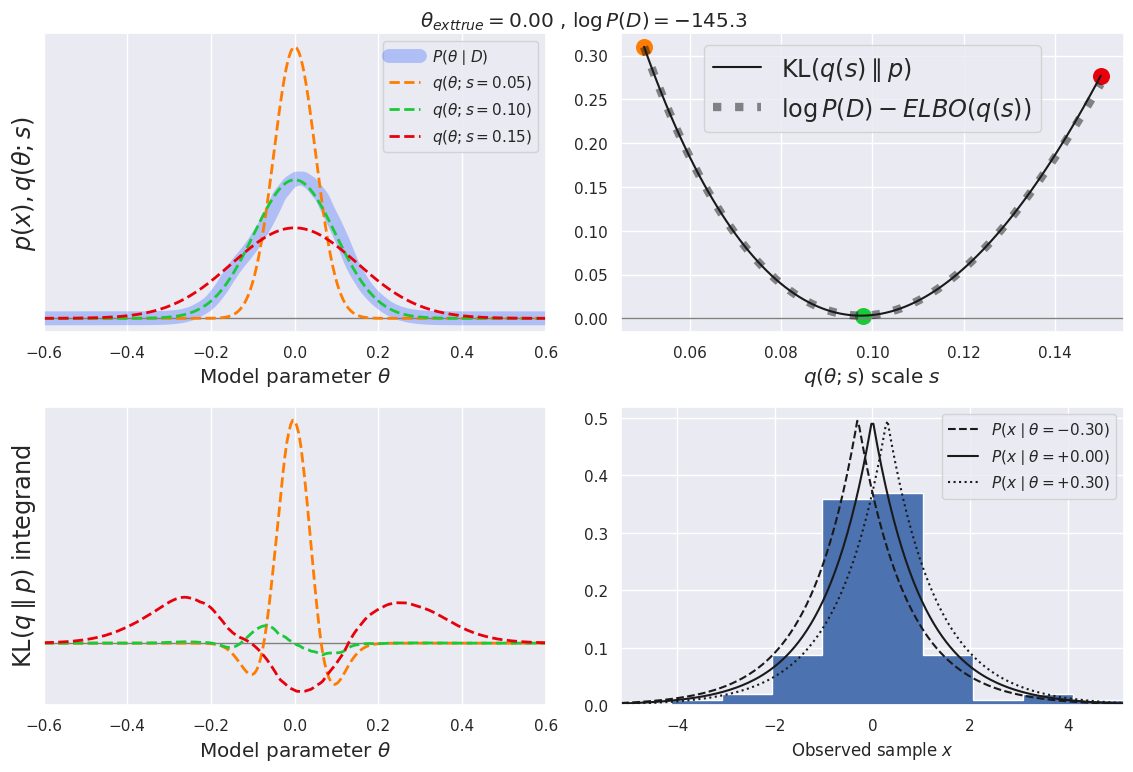

In [19]:
plot_ELBO(q='norm', q_scale_range=[0.05, 0.15], likelihood='laplace', prior='norm',
          theta_range=[-0.6, +0.6], n_data=100)

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:Violet">DISCUSS</span>___
 - Is the offset between the KL divergence and -ELBO significant on the scale of variations shown in the upper-right panel?

 - Is the posterior dominated by the prior or the new data in this example?

 - How do you expect these plots to change when doubling the number of data samples? (think about it before trying it).

The offset equals $\log P(D) \simeq -145$ so is very significant compared with the variations $\simeq 0.3$ shown in the upper-right panel.  However, since the offset is constant (with respect to $s$) it does not affect the location of the minimum.

Referring to the top-left panel, the posterior has a standard deviation $s\simeq 0.1$ but but prior is much wider with $s = 1$, so the posterior is dominated by the new data.

Doubling the number of data samples will make the data even more informative, leading to a narrower posterior. The best-fitting $q$ will therefore also be narrow, leading to a minimum KL divergence (upper-right panel) at a lower value of $s$.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:Violet">EXAMPLE</span>___: Re-run the example above with `n_data` changed from 100 to 200 to confirm these predictions:

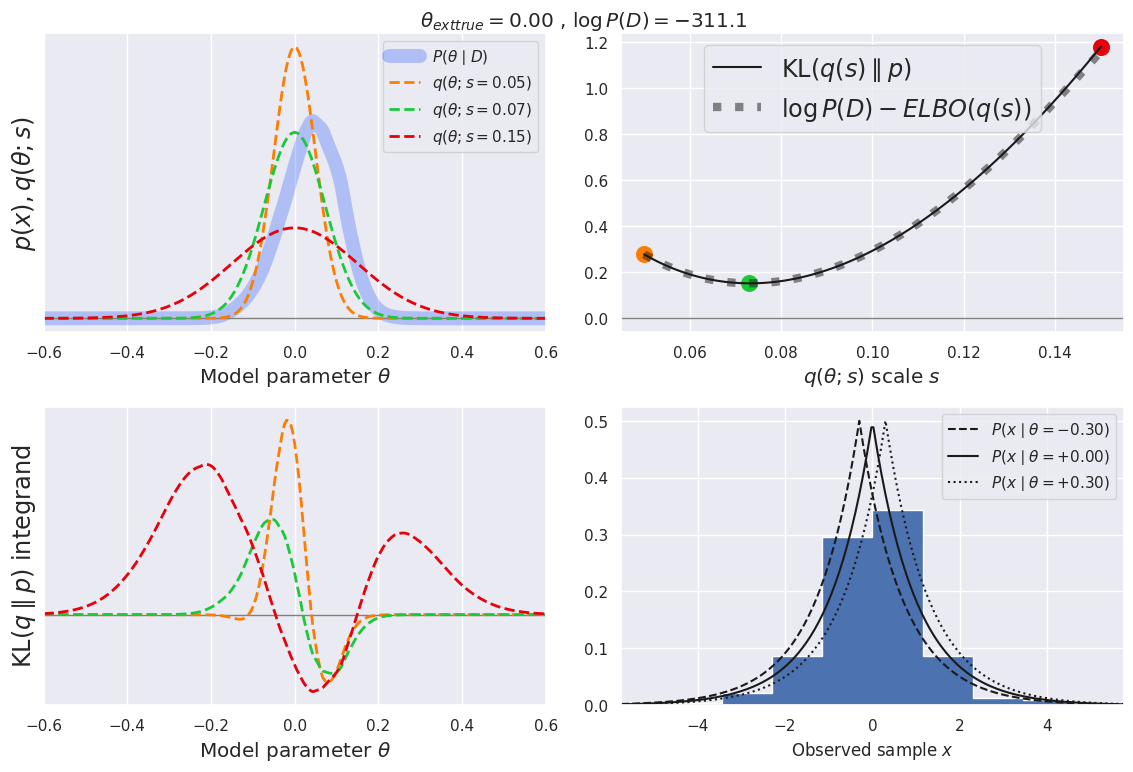

In [20]:
plot_ELBO(q='norm', q_scale_range=[0.05, 0.15], likelihood='laplace', prior='norm',
          theta_range=[-0.6, +0.6], n_data=200)

## <span style="color:Orange">Practical Calculations with VI</span>

MCMC with Metroplis-Hastings updates can be used as a black box for an arbitrary inference problem that only requires that you can calculate your likelihood $P(D\mid \theta)$ and prior $P(\theta)$ for arbitrary parameter values $\theta$.

VI, on the other hand, generally requires more work to setup for a particular problem, but is then often more computationally efficient since it replaces sampling with optimization. A necessary step in any VI inference is to select an approximating family $q$, and this generally requires knowledge of the particular problem and some judgment on how to tradeoff calculational convenience against approximation error.

Once you selected a family $q(\theta; s)$ that is explored by some $s$, you need to be able to:
 - evaluate the KL divergence of $q(s)$ with respect to $p$ for any $s$, and

 - find the value of $s$ that minimizes the KL divergence.
 
There are standard numerical optimization methods for the second step, which perform best when you can evaluate derivatives of $q(s)$ with respect to $s$.  The first step either requires an analytic integral over $\theta$ or a sufficiently accurate numerical approximation to the KL integral. A [recent development](https://arxiv.org/abs/1401.0118) is to use the expectation form of the KL divergence,

$$ \Large
\text{KL}( q \parallel p ) = \langle \log q(\theta)\rangle_q - \langle \log p(\theta)\rangle_q \; ,
$$

to replace the integral with averages. This approach changes our requirements on the family $q$ from being able to do integrals involving $q$ to being able to sample from $q$, which is generally much easier. Although this method is known as <span style="color:Violet">Black Box Variational Inference</span>, it still lacks the turn-key convenience of MCMC with MH updates.

The examples above used a single parameter $\theta$, to simplify plotting and allow straightforward numerical integration. More interesting problems generally have many parameters, which makes picking a suitable family $q$ much harder.  A common approach, known as the <span style="color:Violet">mean field approximation</span>, is to assume that the posterior can be factored:

$$ \Large
P(\theta_1, \theta_2, \ldots\mid D) = p_1(\theta_1)\, p_2(\theta_2) \ldots
$$

This is certainly not true in general, but does break a difficult multidimensional optimization problem into a sequence of simpler 1D optimization problems, so is sometimes necessary.  Note that this approach is not able to capture any correlations between $\theta_i$ and $\theta_j$, so is not a good choice when correlations are expected to be important.

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2026